In [342]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv('wine.csv', header=None)
df.columns = ['Type', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',\
     'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# df.head(5)
filtered_df = df[df['Type'] != 3]
print(filtered_df.groupby('Type').size())

Type
1    59
2    71
dtype: int64


与assgn03相同的数据预处理部分。
原数据每行是一种酒的数据，以逗号分割，这里将其以csv格式读取之后，整理column类型。
之后利用pandas创建一个新的子集，drop掉类型为3的酒，方便后续处理。

In [343]:
y = filtered_df.iloc[:,0]
X = filtered_df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=3)

Mission Accomplished: 将数据分为训练集和测试集，测试集大小为0.3，指定随机化种子使得实验可重复

In [344]:
class LogisticRegression():

    def __init__(self, n_feature = 13, learning_rate = 1e-5, epochs = 100, tolerance = None, patience = 10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        # self.W = np.random.random(n_feature + 1)
        self.W = np.random.uniform(-0.01, 0.01, n_feature + 1)
        self.loss = []
        self.best_loss = np.inf
        self.tol = tolerance
        self.patience = patience
        
    def _linear_tf(self, X):
        return X @ self.W
    
    def _sigmoid(self, z):
        out = 1. / (1. + np.exp(-z))
        return out

    def _map_y(self, y):
        mapper = lambda y: 0 if y == 1 else 1
        return np.array([mapper(yi) for yi in y])

    def _predict_probability(self, X):
        z = self._linear_tf(X)
        return self._sigmoid(z)

    def _loss(self, y, y_pred):
        epsilon = 1e-8
        loss = -np.mean(y * np.log(y_pred + epsilon) + (1-y) * np.log(1-y_pred + epsilon))
        return loss
    
    def _gradient(self, X, y, y_pred):
        return -(y - y_pred) @ X / y.size

    def _preprocess_data(self, X):
        m, n = X.shape
        X_ = np.empty([m, n+1])
        X_[:, 0] = 1
        X_[:, 1:] = X

        return X_

    def BGD(self, X_train, y):

        X_train_bar = self._preprocess_data(X_train)
        y = self._map_y(y)
        epoch_no_improve = 0

        for epoch in range(self.epochs):
            shuffle_index = np.random.permutation(X_train_bar.shape[0])
            X_train_bar = X_train_bar[shuffle_index]
            y = y[shuffle_index]

            y_pred = self._predict_probability(X_train_bar)
            loss = self._loss(y, y_pred)
            scalar_loss = np.sum(loss) / X_train_bar.shape[0] # the shape[0] means the number of weights + bias
            self.loss.append(scalar_loss)

            gradient = self._gradient(X_train_bar, y, y_pred)
            self.W -= self.learning_rate * gradient

            if self.tol is not None:
                if scalar_loss < self.best_loss - self.tol and scalar_loss != 0:
                    # the case where the new loss is good enough
                    # i.e. change of loss is bigger than the tolerance
                    self.best_loss = scalar_loss # we update the best loss
                    epoch_no_improve = 0
                elif np.abs(scalar_loss - self.best_loss) < self.tol:
                    epoch_no_improve += 1
                    if epoch_no_improve == self.patience:
                        print(f'Early stopping at epoch {epoch}')
                        return                

    def plot_loss(self):
        plt.plot(self.loss)
        plt.grid()
        plt.show()
    
    def predict(self, X):
        X = self._preprocess_data(X)
        y_pred = self._predict_probability(X)
        return np.where(y_pred >= 0.5, 1, 0)
    
    def batch_loss(self, y, y_pred):
        loss = np.where( y == y_pred, 0, 1)
        return loss



    

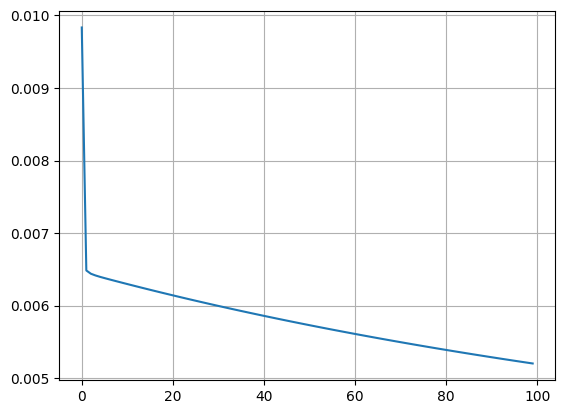

In [345]:
# we need some conversion between numpy and pandas
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

model = LogisticRegression()
model.learning_rate = 1e-5
model.epochs = 100
model.tol = 1e-7
model.BGD(X_train, y_train)
model.plot_loss()


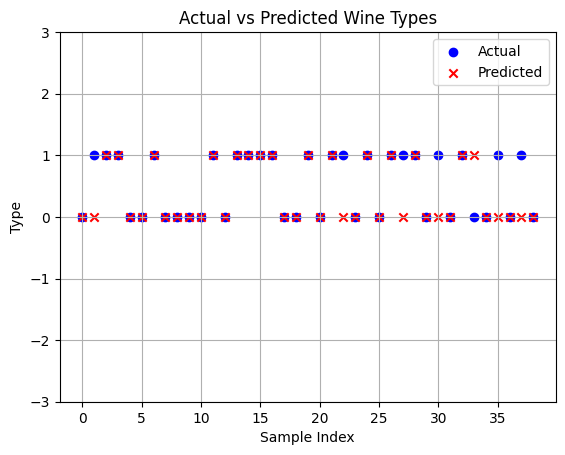

In [346]:
y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test
X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
mapper = lambda y: 0 if y == 1 else 1
y_mapped = np.array([mapper(yi) for yi in y_test])

# Predict the test set
y_pred = model.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(range(len(y_mapped)), y_mapped, color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Type')
plt.ylim(-3,3)
plt.title('Actual vs Predicted Wine Types')
plt.legend()
plt.grid(True)
plt.show()

可以直观看到在测试集上的准确率。接下来使用几个metric来衡量训练结果好坏。

In [347]:
def calculate_accuracy(y_actual, y_pred):

    correct_predictions = 0
    total_predictions = len(y_actual) # 其实y_actual和y_pred的长度是一样的

    for i in range(total_predictions):
        if y_actual[i] == y_pred[i]:
            correct_predictions += 1

    return correct_predictions / total_predictions

def calculate_recall(y_actual, y_pred, positive_label=1):
    true_positive = 0
    false_negative = 0

    for i in range(len(y_actual)):
        if y_actual[i] == positive_label:
            if y_pred[i] == positive_label:
                true_positive += 1
            else:
                false_negative += 1

    recall = true_positive / (true_positive + false_negative)
    # tp + fn 为真值的总数
    return recall

def calculate_precision(y_actual, y_pred, positive_label=1):
    true_positive = 0
    false_positive = 0

    for i in range(len(y_actual)):
        if y_pred[i] == positive_label:
            if y_actual[i] == positive_label:
                true_positive += 1
            else:
                false_positive += 1

    precision = true_positive / (true_positive + false_positive)
    # 在预测为正的情况下，有多少是真的正值
    # 如果模型过多地判定正值，那么recall会很高，但是precision会很低
    # 如果模型过多地判定负值，那么recall会很低，但是在判定为真值的样本里真值往往更多。（过于保守）
    
    return precision

def calculate_f1_score(y_actual, y_pred, positive_label=1):
    precision = calculate_precision(y_actual, y_pred, positive_label)
    recall = calculate_recall(y_actual, y_pred, positive_label)

    f1_score = 2 * precision * recall / (precision + recall)
    # 理想值是precision = 1, recall = 1.
    # 在两者数量相等的时候，f1_score比较高。
    return f1_score


accuracy = calculate_accuracy(y_mapped, y_pred)
recall = calculate_recall(y_mapped, y_pred)
precisio = calculate_precision(y_mapped, y_pred)
f1_score = calculate_f1_score(y_mapped, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precisio}')
print(f'F1 Score: {f1_score}')


Accuracy: 0.8205128205128205
Recall: 0.7
Precision: 0.9333333333333333
F1 Score: 0.8


总结：以上几个都是重要的衡量metric。

accuracy 是正确值的数量
recall 是真值的召回数量
precision 是正确真值的比例
F1 Score 是综合考量recall和precision之后的分数